In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, ParameterGrid, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
SEED = 3            # semilla para reproductibilidad
SR = 2000           # sampling rate
N_FFT = 256         # tamaño de la ventana
HOP_LENGTH = 63     # salto entre frames
N_MELS = 64         # frequency bins (resolución)
MAX_FREQ = 600      # máxima frecuencia para los espectrogramas --ponerlo en 500--

In [3]:
def load_data(train_path:str, test_path:str, labels_path:str, sampling_rate=SR):
    test_files = [f for f in os.listdir(test_path) if f.endswith('.aiff')]
    labels_df = pd.read_csv(labels_path)

    audio_df = labels_df.copy()
    audio_df['filepath'] = audio_df['clip_name'].apply(lambda x: os.path.join(train_path, x))
    audio_df['audio'] = audio_df['filepath'].apply(lambda path: librosa.load(path, sr=sampling_rate)[0])

    return audio_df, labels_df, test_files

def get_melspectrogram(sample:pd.DataFrame, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spectrogram = librosa.feature.melspectrogram(y=np.array(sample), sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=MAX_FREQ)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

def get_all_mel_spectrograms(audio_df, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_specs = []
    for audio in audio_df['audio']:
        mel = get_melspectrogram(audio, sampling_rate, n_fft, hop_length, n_mels)
        mel_specs.append(mel.flatten())
    return np.array(mel_specs)

# -----------------------------------------------

def normalize_spectrogram(spec, global_min, global_max):
    norm_spec = (spec - global_min) / (global_max - global_min + 1e-8)
    return norm_spec

def denormalize_spectrogram(norm_spec, min_val, max_val):
    return norm_spec * (max_val - min_val + 1e-8) + min_val

def compute_global_min_max(audio_df):
    whale_specs = [get_melspectrogram(audio) for audio, label in zip(audio_df['audio'], audio_df['label']) if label == 1]
    global_min = np.min([spec.min() for spec in whale_specs])
    global_max = np.max([spec.max() for spec in whale_specs])
    return global_min, global_max

def get_class_weights(y):
    weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    return torch.tensor(weights, dtype=torch.float32)

def get_data_loaders(train_df):
    X = get_all_mel_spectrograms(train_df)
    y = train_df['label'].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)

    return train_loader, val_loader


In [4]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir)

In [5]:
audio_train_df = audio_df[audio_df['clip_name'].str.contains('train')]
print(audio_train_df.head())

     clip_name  label                                           filepath  \
0  train1.aiff      0  data/whale-detection-challenge/data/train\trai...   
1  train2.aiff      0  data/whale-detection-challenge/data/train\trai...   
2  train3.aiff      0  data/whale-detection-challenge/data/train\trai...   
3  train4.aiff      0  data/whale-detection-challenge/data/train\trai...   
4  train5.aiff      0  data/whale-detection-challenge/data/train\trai...   

                                               audio  
0  [0.009246826, -0.004272461, -0.005065918, -0.0...  
1  [0.0022583008, 0.0061035156, -0.0006713867, -0...  
2  [-0.006011963, 0.0070495605, 0.0024108887, -0....  
3  [-0.0037231445, 0.0, -0.0010070801, 0.00137329...  
4  [0.008911133, -0.007873535, 0.0013427734, 0.00...  


In [6]:
whale_audios = audio_df[audio_df['label'] == 1]

In [7]:
mel_specs = []
for whale_audio in whale_audios['audio']:
    mel = get_melspectrogram(whale_audio) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    mel_specs.append(mel)

In [8]:
X = np.array(mel_specs)

global_mean = X.mean()
global_std = X.std()

X = (X - global_mean) / (global_std + 1e-8)
print(f"Global mean: {global_mean}, Global std: {global_std}")
print(f"Shape of X: {X.shape}")

Global mean: -21.893871307373047, Global std: 11.335022926330566
Shape of X: (7027, 1, 64, 64)


In [9]:
X_tensor = torch.tensor(X, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=128, shuffle=True)

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()  # Match VAE structure
        )
        self.fc = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Tanh()  # Match GAN / VAE
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 256, 4, 4)
        return self.deconv(x)

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

In [11]:
print(torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

False
Using device: cpu


In [ ]:
# Entrenamiento
latent_dim = 32
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
discriminator = Discriminator(latent_dim).to(device)

opt_autoenc = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
opt_disc = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

bce = nn.BCELoss(reduction="sum")
recon_loss_fn = nn.MSELoss(reduction="sum")

for epoch in range(50):
    encoder.train(); decoder.train(); discriminator.train()
    total_recon, total_disc, total_gen = 0, 0, 0

    for batch in train_loader:
        x = batch[0].to(device)

        # Reconstruccion
        z = encoder(x)
        x_recon = decoder(z)
        recon_loss = recon_loss_fn(x_recon, x)

        opt_autoenc.zero_grad()
        recon_loss.backward()
        opt_autoenc.step()

        # Discriminador
        z_real = torch.randn_like(z)
        z_fake = encoder(x).detach()
        d_real = discriminator(z_real)
        d_fake = discriminator(z_fake)

        disc_loss = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Generador (Encoder)
        z_fake = encoder(x)
        d_fake = discriminator(z_fake)
        gen_loss = bce(d_fake, torch.ones_like(d_fake))

        opt_autoenc.zero_grad()
        gen_loss.backward()
        opt_autoenc.step()

        total_recon += recon_loss.item()
        total_disc += disc_loss.item()
        total_gen += gen_loss.item()

    print(f"Epoch [{epoch}] Recon: {total_recon:.2f}, Disc: {total_disc:.2f}, Gen: {total_gen:.2f}")

Epoch [0] Recon: 13549833.48, Disc: 4394.89, Gen: 18416.08
Epoch [1] Recon: 10490970.75, Disc: 1087.37, Gen: 26198.66
Epoch [2] Recon: 10282161.36, Disc: 737.61, Gen: 36943.09
Epoch [3] Recon: 10140562.38, Disc: 542.26, Gen: 40510.89
Epoch [4] Recon: 10065923.16, Disc: 1046.77, Gen: 42565.74
Epoch [5] Recon: 9815635.25, Disc: 1248.32, Gen: 39027.49
Epoch [6] Recon: 9692972.42, Disc: 2413.70, Gen: 32798.20
Epoch [7] Recon: 9621548.80, Disc: 2732.10, Gen: 29178.98
Epoch [8] Recon: 9512753.80, Disc: 2774.59, Gen: 26419.38
Epoch [9] Recon: 9438246.50, Disc: 2786.60, Gen: 24359.67
Epoch [10] Recon: 9397568.55, Disc: 2011.71, Gen: 24267.04
Epoch [11] Recon: 9350662.16, Disc: 1731.44, Gen: 26036.98
Epoch [12] Recon: 9308583.94, Disc: 1868.38, Gen: 27329.95
Epoch [13] Recon: 9282421.92, Disc: 1933.00, Gen: 26955.16
Epoch [14] Recon: 9239615.06, Disc: 2500.16, Gen: 24476.01
Epoch [15] Recon: 9232508.08, Disc: 2007.02, Gen: 26031.17
Epoch [16] Recon: 9193350.75, Disc: 2377.29, Gen: 25168.02
Epoc

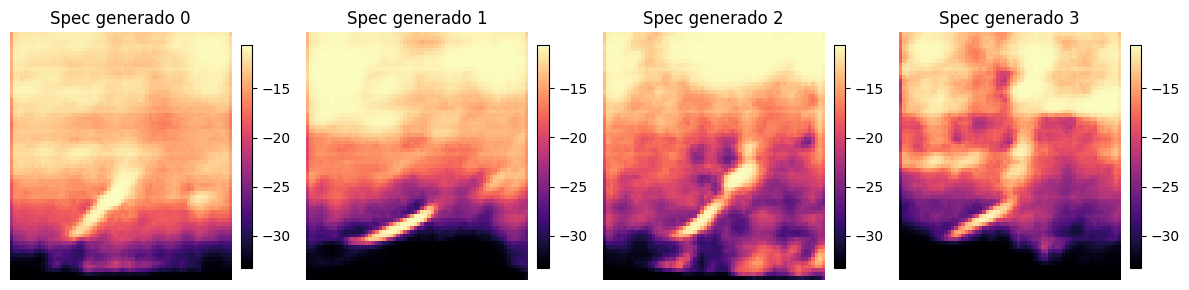

In [13]:
with torch.no_grad():
    z_samples = torch.randn(4, 32).to(device)
    generated_specs = decoder(z_samples)

generated_specs = generated_specs.cpu().numpy()

fig, axes = plt.subplots(1, generated_specs.shape[0], figsize=(3 * generated_specs.shape[0], 3))
for i in range(generated_specs.shape[0]):
    spec = generated_specs[i, 0, :, :]
    spec = spec * global_std + global_mean
    ax = axes[i] if generated_specs.shape[0] > 1 else axes
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"Spec generado {i}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [14]:
import librosa
import numpy as np

generated_spec = generated_specs[0]  # Tomamos el primer espectrograma generado
spec = generated_spec[0, :, :]  # [64, 64]

# 1️⃣ Desnormalizar
spec = spec * global_std + global_mean

# 2️⃣ Si era Mel, invertir a espectrograma lineal
mel_spec = spec
mel_basis = librosa.filters.mel(sr=SR, n_fft=N_FFT, n_mels=N_MELS)

# Invertir Mel -> STFT
spec_inv = np.linalg.pinv(mel_basis).dot(np.exp(mel_spec))
# Invertir STFT -> Audio
audio = librosa.griffinlim(spec_inv, hop_length=HOP_LENGTH, n_fft=N_FFT)

# Ahora 'audio' es un array de muestras PCM
from IPython.display import Audio
Audio(audio, rate=SR*1.5)

In [15]:
# Entrenamiento
latent_dim = 32
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
discriminator = Discriminator(latent_dim).to(device)

opt_autoenc = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
opt_disc = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

bce = nn.BCELoss()          # usa reduction="mean" por defecto
recon_loss_fn = nn.MSELoss()

for epoch in range(50):
    encoder.train(); decoder.train(); discriminator.train()
    total_recon, total_disc, total_gen = 0, 0, 0

    for batch in train_loader:
        x = batch[0].to(device)

        # Reconstruccion
        z = encoder(x)
        x_recon = decoder(z)
        recon_loss = recon_loss_fn(x_recon, x)

        opt_autoenc.zero_grad()
        recon_loss.backward()
        opt_autoenc.step()

        # Discriminador
        z_real = torch.randn_like(z)
        z_fake = encoder(x).detach()
        d_real = discriminator(z_real)
        d_fake = discriminator(z_fake)

        disc_loss = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Generador (Encoder)
        z_fake = encoder(x)
        d_fake = discriminator(z_fake)
        gen_loss = bce(d_fake, torch.ones_like(d_fake))

        opt_autoenc.zero_grad()
        gen_loss.backward()
        opt_autoenc.step()

        total_recon += recon_loss.item()
        total_disc += disc_loss.item()
        total_gen += gen_loss.item()

    print(f"Epoch [{epoch}] Recon: {total_recon:.2f}, Disc: {total_disc:.2f}, Gen: {total_gen:.2f}")

Epoch [0] Recon: 32.46, Disc: 3060.53, Gen: 18.91
Epoch [1] Recon: 26.04, Disc: 86.78, Gen: 45.35
Epoch [2] Recon: 21.77, Disc: 80.34, Gen: 36.46
Epoch [3] Recon: 21.75, Disc: 80.75, Gen: 36.48
Epoch [4] Recon: 21.05, Disc: 82.62, Gen: 35.34
Epoch [5] Recon: 20.55, Disc: 79.69, Gen: 35.89
Epoch [6] Recon: 20.43, Disc: 79.19, Gen: 35.69
Epoch [7] Recon: 21.89, Disc: 79.80, Gen: 34.75
Epoch [8] Recon: 21.86, Disc: 86.61, Gen: 39.67
Epoch [9] Recon: 20.58, Disc: 79.66, Gen: 36.69
Epoch [10] Recon: 20.41, Disc: 81.37, Gen: 35.86
Epoch [11] Recon: 20.01, Disc: 79.53, Gen: 36.98
Epoch [12] Recon: 20.52, Disc: 79.18, Gen: 35.69
Epoch [13] Recon: 20.05, Disc: 79.15, Gen: 37.16
Epoch [14] Recon: 20.03, Disc: 78.17, Gen: 37.01
Epoch [15] Recon: 20.03, Disc: 78.19, Gen: 37.53
Epoch [16] Recon: 19.70, Disc: 76.61, Gen: 37.14
Epoch [17] Recon: 20.19, Disc: 79.22, Gen: 37.29
Epoch [18] Recon: 19.60, Disc: 78.06, Gen: 37.13
Epoch [19] Recon: 19.67, Disc: 78.27, Gen: 37.25
Epoch [20] Recon: 19.54, Dis

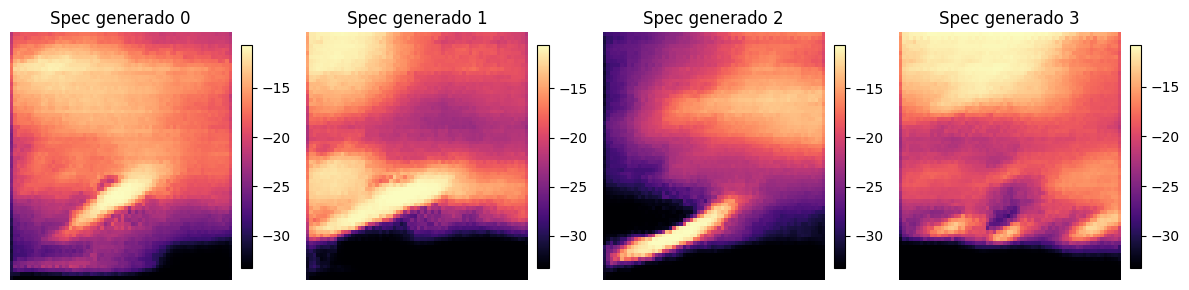

In [16]:
with torch.no_grad():
    z_samples = torch.randn(4, 32).to(device)
    generated_specs = decoder(z_samples)

generated_specs = generated_specs.cpu().numpy()

fig, axes = plt.subplots(1, generated_specs.shape[0], figsize=(3 * generated_specs.shape[0], 3))
for i in range(generated_specs.shape[0]):
    spec = generated_specs[i, 0, :, :]
    spec = spec * global_std + global_mean
    ax = axes[i] if generated_specs.shape[0] > 1 else axes
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"Spec generado {i}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()